In [3]:
!pip install geffnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [1]:
import os
import glob
import cv2
import time
import random
import librosa as lb
import soundfile as sf
import geffnet
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader,Dataset, RandomSampler
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import label_ranking_average_precision_score
from librosa import display
from sklearn.model_selection import StratifiedKFold, GroupKFold
import matplotlib.pyplot as plt
import seaborn as sns
from torch.cuda import amp

PARAM = 260
if PARAM == 260:
    PATH_DATA = '../input/experement-make-img-sr48power2mel260-reinforest/train_img.zip'
else:
    PATH_DATA = '../input/experement-make-img-sr32power2mel384-ff111-pow/train_img.zip'    
    
print(np.load(PATH_DATA)['train/3f3c49ad2.10.301'].shape)
SEED = 13
PATH_MODEL = './'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

(260, 563)


/opt/conda/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/opt/conda/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


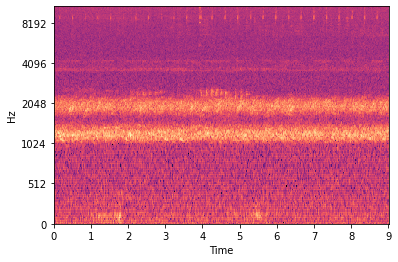

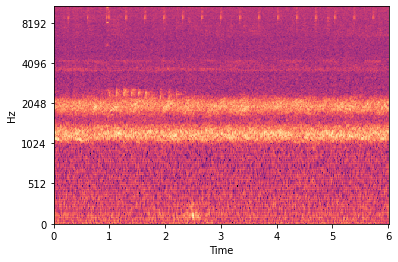

In [7]:
def rand_window(data: np.array)->np.array:
    """
    we cut data 384.563 = 10 sec by random start and all time len ~6sec 384*384
    
    
    test data shape (384, 376)
    """
    if PARAM == 260:
        current_len = 844 # ~ 10 sec
        cut_len = 563 # ~ 6 sec   
    else:
        current_len = 563 # ~ 10 sec
        cut_len = 376 # ~ 6 sec  
        
    start = np.random.randint(0, current_len - cut_len)
    len_img = (start + cut_len) - start
    assert len_img == cut_len, f'error len {start}, {start + cut_len}'
    return data[:, start: start + cut_len]  


data = np.load(PATH_DATA)
npy = data['train/8e56d782f.16.692']
npy_cut = rand_window(npy)
print(npy_cut.shape)
librosa.display.specshow(npy, sr = 48000, y_axis='mel', x_axis='time')
plt.show()
librosa.display.specshow(npy_cut, sr = 48000, y_axis='mel', x_axis='time');    
plt.show()

In [ ]:
tmp = []
for _ in range(30):
    start = np.random.randint(563-384)
    len_img = (start + 384) - start
    assert len_img == 384, f'error len {start}, {start + 384}'
    tmp.append(start)    

ax = sns.distplot(tmp)

In [8]:
df = pd.read_csv('../input/rfcx-species-audio-detection/train_tp.csv')

df['dif_f'] = df.f_max - df.f_min
df['dif_f'] = df['dif_f'].astype(int)
df['bins'] = pd.cut(df.dif_f, 15, labels=False)
df

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,dif_f,bins
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25,3000,3
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40,4048,5
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25,2718,3
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04,3100,3
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70,9905,14
...,...,...,...,...,...,...,...,...,...
1211,fe8d9ac40,13,1,53.4720,93.750,54.0960,843.75,750,0
1212,fea6b438a,4,1,43.5787,2531.250,45.7653,4031.25,1500,1
1213,ff2eb9ce5,0,1,15.2267,5906.250,16.0213,8250.00,2343,2
1214,ffb8d8391,5,1,14.3467,4781.250,16.6987,10406.20,5624,7


In [9]:
df['file_name'] = 'file_name'
data = np.load(PATH_DATA)
for i in data.files[1:]:
    recording_id, species_id, idx = i.split('.')[0], i.split('.')[1], i.split('.')[2]
    if (df.loc[int(idx), 'recording_id'] == recording_id.split('/')[1] and df.loc[int(idx), 'species_id'] == int(species_id)):
        df.loc[int(idx),'file_name'] = i
    else:
        print(idx, recording_id, i)
        
df.head()

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,dif_f,bins,file_name
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25,3000,3,train/003bec244.14.0
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40,4048,5,train/006ab765f.23.1
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25,2718,3,train/007f87ba2.12.2
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04,3100,3,train/0099c367b.17.3
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70,9905,14,train/009b760e6.10.4


In [11]:
rec = []
tr_idx = []
vl_idx = []
data = np.load(PATH_DATA)
# for name in data.files[1:]:
#     rec_id = name.split('.')[0].split('/')[1]    
#     rec.append(rec_id)   
    
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
if PARAM == 260:
    for f, (tr, vl) in enumerate(skf.split(data.files[1:], df.bins.values)):
        print(len(tr), len(vl))
        tr_idx.append(tr)
        vl_idx.append(vl) 
    a = np.take(data.files[1:], tr_idx[0])
else:
    for f, (tr, vl) in enumerate(skf.split(df, df.bins.values)):
        print(len(tr), len(vl))
        tr_idx.append(tr)
        vl_idx.append(vl)
    a = np.take(df.file_name.values, tr_idx[0])

972 244
973 243
973 243
973 243
973 243


In [12]:
def mono_to_color(X: np.ndarray,
                  mean=None,
                  std=None,
                  norm_max=None,
                  norm_min=None,
                  eps=1e-6):
    """
    Code from https://www.kaggle.com/daisukelab/creating-fat2019-preprocessed-data
    """
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

class RFDataset(Dataset):

    def __init__(self, data, size, transform = False):        
        self.size = size     
        self.transform = transform260
        self.zipdata = np.load(PATH_DATA)
        self.data = data # list name npy,
        
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        name = self.data[index]      
     
        img_ori = self.zipdata[name]  
        img = rand_window(img_ori)
        sci_id = name.split('.')[1]
        target = np.zeros(24)
        target[int(sci_id)] = 1
        if self.transform is not None:
            pass
        img = mono_to_color(img)       
        if self.size is not None:
            img = cv2.resize(img, (224, self.size)) 
            
        img = img / 255.0
        img = img.transpose(2, 0, 1).astype(np.float32)        
             
        return torch.tensor(img).float(),torch.tensor(target.astype(np.float16)).float()

torch.Size([3, 260, 563]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0.])


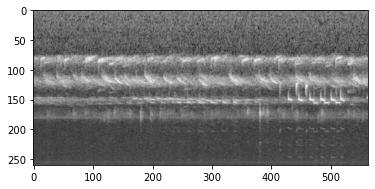

In [13]:
d = RFDataset(a, size = None)
img, target = d[5]
print(img.shape, target)
plt.imshow(np.transpose(img, (1,2,0)))

In [14]:
sigmoid = torch.nn.Sigmoid()

class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * sigmoid(i)
        ctx.save_for_backward(i)
        return result
    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0]
        sigmoid_i = sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))
swish = Swish.apply

class Swish_module(nn.Module):
    def forward(self, x):
        return swish(x)
    
swish_layer = Swish_module()
    

class EffB3_260(nn.Module):

  def __init__(self):
    super(EffB3, self).__init__()
    self.model = geffnet.create_model('tf_efficientnet_lite4', pretrained=True) 
    self.model.global_pool = nn.AdaptiveAvgPool2d((1,1)) 
    in_ch = self.model.classifier.in_features 
    self.myfc = nn.Sequential(
        nn.Dropout(0.17418),
        nn.Linear(in_ch, 785),
        nn.BatchNorm1d(785),
        Swish_module(),
        nn.Dropout(0.12),         
        nn.Linear(785, 1038),
        nn.BatchNorm1d(1038),
        Swish_module(),
        nn.Dropout(0.3763722),       
        nn.Linear(1038, 24)
    )   
    
    self.model.classifier = nn.Identity()   
      
  def extract(self, x):        
    x = self.model(x)        
    return x
      
  def forward(self, x):    
    if len(torch.squeeze(x).shape) == 4:
        x = torch.squeeze(x)
    else:
        x
    bs, _, _, _ = x.shape    
    x = self.extract(x)   
    x = self.myfc(x)
    return x

class EffB3_384(nn.Module):

  def __init__(self):
    super(EffB3, self).__init__()
    self.model = geffnet.create_model('tf_efficientnet_lite4', pretrained=True) 
    self.model.global_pool = nn.AdaptiveAvgPool2d((1,1)) 
    in_ch = self.model.classifier.in_features
    self.myfc = nn.Sequential(
        nn.Dropout(0.29),
        nn.Linear(in_ch, 1307),
        nn.BatchNorm1d(1307),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(1307, 1307),
        nn.BatchNorm1d(1307),
        nn.ReLU(),
        nn.Dropout(0.2),         
        nn.Linear(1307, 24)
    )   
    
    self.model.classifier = nn.Identity()   
      
  def extract(self, x):        
    x = self.model(x)        
    return x
      
  def forward(self, x):    
    if len(torch.squeeze(x).shape) == 4:
        x = torch.squeeze(x)
    else:
        x
    bs, _, _, _ = x.shape    
    x = self.extract(x)
    x = self.myfc(x)
    return x 

if PARAM == 260:
    EffB3 = EffB3_260
else:
    EffB3 = EffB3_384  

In [18]:
def _one_sample_positive_class_precisions(scores, truth):
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)

    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)

    retrieved_classes = np.argsort(scores)[::-1]

    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)

    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True

    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)

    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits

def lwlrap(truth, scores):
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = _one_sample_positive_class_precisions(scores[sample_num, :], truth[sample_num, :])
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = precision_at_hits

    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))

    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    return per_class_lwlrap, weight_per_class

y_true = np.array([[1, 0, 0], [0, 0, 1]])
y_score = np.array([[0.75, 0.5, 1], [1, 0.2, 0.1]])

score_class, weight = lwlrap(y_true, y_score)
score = (score_class * weight).sum()

In [19]:
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


def  train(model, loader, loss_f, optimizer, scaler):
    model.train()
    bar = tqdm(loader)
    train_loss = []
    train_target = []
    train_prob = []
    for (img, target) in bar:
        optimizer.zero_grad()
        img, target = img.to(device), target.to(device)
        y_ = model(img)
        pred = loss_f(y_, target)
        pred.backward()
        optimizer.step()        
        train_loss.append(pred.detach().cpu().numpy())
        prob = nn.Sigmoid()(y_) 
    return train_loss


def val_train(model, loader, loss_f):
    val_loss = []
    target_temp = []
    probs = [] 
    val_corr = []
    model.eval()
    with torch.no_grad():
        bar = tqdm(loader)
        for (img, target) in bar:
            img, target = img.to(device), target.to(device)
            y_ = model(img)             
            pred = loss_f(y_, target)            
            prob = nn.Sigmoid()(y_) 
            _, tar_idx = torch.max(target, dim= 1)
            _, ans_idx = torch.max(y_, dim= 1) #dim=0 values, if dim =1 return max value and index max value
            corrects = 0
            for i in range(0, len(ans_idx)):
                if ans_idx[i] == tar_idx[i]:
                    corrects = corrects + 1
            val_corr.append(corrects)
            val_loss.append(pred.detach().cpu())        
            probs.append(prob.detach().cpu())
            target_temp.append(target.detach().cpu())           
    val_loss = np.mean(val_loss) 
    val_corr = np.sum(val_corr)
    probs =  torch.cat(probs).numpy()   
    target = torch.cat(target_temp).numpy()  
    pr = average_precision_score(target, probs, average='weighted')
    pr_m = average_precision_score(target, probs, average='micro')    
    score_class, weight = lwlrap(target, probs)
    LWLRAP = (score_class * weight).sum()
    lraps = label_ranking_average_precision_score(target, probs)
    score_loss = 0
    
    print(f'Correct ---------{np.sum(val_corr)}/{len(target)}')    
    auc = roc_auc_score(target, probs)
    correct = np.sum(val_corr)
    return val_loss, auc, lraps, score_loss, pr,pr_m, correct, LWLRAP


def showtime(model, f: int, data, tr_idx: np.array, vl_idx: np.array, scaler):
    start = time.ctime().replace('  ', ' ').replace(' ', '_')    
    print('Fold: ', f)
    
    if PARAM == 260:
        tr = np.take(data.files[1:], tr_idx[f])
        vl = np.take(data.files[1:], vl_idx[f])
    else:
        tr = np.take(data.file_name.values, tr_idx[f])
        vl = np.take(data.file_name.values, vl_idx[f])
    print(f'USED PARAM---> {PARAM}')
    print(tr.shape, vl.shape)
    
    tr_dataset = RFDataset(tr, size = None)
    vl_dataset = RFDataset(vl, size = None)
    
    tr_loader = DataLoader(tr_dataset, batch_size=14, num_workers=1,
                           sampler=RandomSampler(tr_dataset))
    vl_loader = DataLoader(vl_dataset, batch_size=14, num_workers=1)    

    kernel_type = type(model).__name__
    model = model.to(device)
    # need addd pos_weight 
    pos_weights = torch.ones(24)
    pos_weights = pos_weights * 24    
    loss_f = nn.BCEWithLogitsLoss(reduction="mean", pos_weight=pos_weights).to(device)       
    optimizer = optim.Adam(model.parameters())
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.9, patience=3, verbose=True)

    lraps_max = 0
    loss = np.inf
    correct_max = 0
    early_stop_iter = 10
    early_stop_count = 0
    for ep in range(30):
        print('Epoch: ', ep + 1)
        
        train_loss= train(model, tr_loader, loss_f, optimizer, scaler)
        val_loss, auc, lraps, score_loss, pr,pr_m, correct, LWLRAP = val_train(model, vl_loader, loss_f)

        log = time.ctime().replace('  ', ' ').replace(' ', '_') + ',' + f'Fold:{f},Epoch:{ep},lr:{optimizer.param_groups[0]["lr"]:.7f},Auc_val:{auc:.5f},LRAPS:{LWLRAP:.5f},lwlrap:{lraps:.5f},tr_loss:{np.mean(train_loss):.5f},val_loss:{val_loss:.5f}'
               
        print(log)
        if (lraps > lraps_max) and (val_loss < loss) :
            print(f'lraps_max: {lraps} --> {lraps_max}, PRw: {pr}, PRmicro: {pr_m}). Saving model ...')
            print(f'Loss: {loss} --> {val_loss}')
            torch.save(model.state_dict(), os.path.join(PATH_MODEL, f'{kernel_type}_best_fold_{f}.pth'))
            lraps_max = lraps
            loss = val_loss
#         if ep > 5:
#             if correct > correct_max:
#                 print(f'correct_max: {correct} --> {correct_max}, PRw: {pr}, PRmicro: {pr_m}). Saving model ...')
#                 torch.save(model.state_dict(), os.path.join(PATH_MODEL, f'{kernel_type}_best_correct_fold_{f}.pth'))
#                 correct_max = correct  
        
        scheduler.step(val_loss) 
#         scheduler.step()
    torch.cuda.empty_cache()   

In [ ]:
set_seed(SEED)
scaler = amp.GradScaler()  
for i in range(0, 5):
    model = EffB3()
    showtime(model, i, data, tr_idx, vl_idx, scaler)